#CoST Model

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Step 1: Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the financial data
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File {file_path} not found")
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])

    # Add quarter information
    df['Quarter'] = df['Date'].dt.year.astype(str) + 'Q' + df['Date'].dt.quarter.astype(str)

    # Add month within quarter (1-3)
    df['MonthInQuarter'] = ((df['Date'].dt.month - 1) % 3) + 1

    # Create sector column (for this example, we'll use the ticker as sector proxy)
    sector_mapping = {
        'XLE': 'Energy',
        'XLF': 'Financial',
        'XLI': 'Industrial',
        'XLK': 'Technology',
        'XLV': 'Healthcare',
        'XLY': 'Consumer Discretionary',
        '^GSPC': 'Market'
    }
    df['Sector'] = df['Ticker'].map(sector_mapping)

    # Calculate returns
    df['Returns'] = df.groupby('Ticker')['Close'].pct_change()

    # Get volatility (20-day rolling standard deviation of returns)
    df['Volatility'] = df.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(20).std())

    # Calculate moving averages
    df['MA50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    df['MA200'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(200).mean())

    # Calculate Relative Strength Index (RSI) - FIXED
    # For each ticker, calculate RSI separately
    for ticker in df['Ticker'].unique():
        ticker_mask = df['Ticker'] == ticker
        delta = df.loc[ticker_mask, 'Close'].diff()

        gain = delta.copy()
        gain[gain < 0] = 0

        loss = -delta.copy()
        loss[loss < 0] = 0

        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        df.loc[ticker_mask, 'RSI'] = rsi

    # Create monthly data by sector to capture seasonal patterns within quarters
    monthly_data = df.groupby(['Quarter', 'Sector', 'MonthInQuarter']).agg({
        'Returns': 'mean',
        'Volatility': 'mean',
        'RSI': 'mean',
        'Volume': 'mean',
        'Close': lambda x: x.iloc[-1] / x.iloc[0] - 1  # Monthly performance
    }).reset_index()

    # Also create quarterly data for our main trend model
    quarterly_data = df.groupby(['Quarter', 'Sector']).agg({
        'Returns': 'mean',
        'Volatility': 'mean',
        'RSI': 'mean',
        'Volume': 'mean',
        'Close': lambda x: x.iloc[-1] / x.iloc[0] - 1  # Quarter performance
    }).reset_index()

    # Drop NaN values
    monthly_data = monthly_data.dropna()
    quarterly_data = quarterly_data.dropna()

    # Create trend label (simplified for example)
    quarterly_data['Trend'] = quarterly_data['Close'].apply(lambda x: 1 if x > 0 else 0)

    return df, quarterly_data, monthly_data

# Step 2: Create Time Series Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, features, targets=None, is_train=True):
        self.data = data
        self.seq_length = seq_length
        self.features = features
        self.targets = targets
        self.is_train = is_train

        # Normalize features
        self.scalers = {}
        self.scaled_data = {}

        for feature in features:
            scaler = StandardScaler()
            self.scaled_data[feature] = scaler.fit_transform(data[feature].values.reshape(-1, 1)).flatten()
            self.scalers[feature] = scaler

        if targets is not None and is_train:
            self.target_scaler = StandardScaler()
            self.scaled_targets = self.target_scaler.fit_transform(data[targets].values.reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = np.array([self.scaled_data[feature][idx:idx+self.seq_length] for feature in self.features]).T

        if self.is_train and self.targets is not None:
            y = self.scaled_targets[idx+self.seq_length-1]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        else:
            return torch.tensor(x, dtype=torch.float32)

    def inverse_transform_target(self, y):
        return self.target_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Step 3: CoST Model Implementation
class InstanceNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True) + self.eps
        x = (x - mean) / std
        return x

class CoSTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2):
        super().__init__()
        self.instance_norm = InstanceNorm()

        # Seasonal encoder (captures periodic patterns)
        self.seasonal_encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.seasonal_projection = nn.Linear(hidden_dim, latent_dim)

        # Trend encoder (captures long-term trends)
        self.trend_encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.trend_projection = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # Apply instance normalization
        x_normalized = self.instance_norm(x)

        # Encode seasonal component
        seasonal_out, _ = self.seasonal_encoder(x_normalized)
        seasonal_last = seasonal_out[:, -1, :]
        seasonal_representation = self.seasonal_projection(seasonal_last)

        # Encode trend component
        trend_out, _ = self.trend_encoder(x)
        trend_last = trend_out[:, -1, :]
        trend_representation = self.trend_projection(trend_last)

        return seasonal_representation, trend_representation

class CoSTModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_layers=2, temperature=0.1):
        super().__init__()
        self.encoder = CoSTEncoder(input_dim, hidden_dim, latent_dim, num_layers)
        self.temperature = temperature

        # Decoder for forecasting
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        seasonal_repr, trend_repr = self.encoder(x)
        combined_repr = torch.cat([seasonal_repr, trend_repr], dim=1)
        prediction = self.decoder(combined_repr)
        return prediction, seasonal_repr, trend_repr

    def contrastive_loss(self, seasonal_repr, trend_repr, batch_size):
        # Normalize representations for cosine similarity
        seasonal_repr = nn.functional.normalize(seasonal_repr, dim=1)
        trend_repr = nn.functional.normalize(trend_repr, dim=1)

        # Calculate cosine similarity matrices
        seasonal_sim = torch.matmul(seasonal_repr, seasonal_repr.T) / self.temperature
        trend_sim = torch.matmul(trend_repr, trend_repr.T) / self.temperature

        # Create labels for positive pairs
        labels = torch.arange(batch_size, device=seasonal_repr.device)

        # InfoNCE loss for both seasonal and trend
        seasonal_loss = nn.functional.cross_entropy(seasonal_sim, labels)
        trend_loss = nn.functional.cross_entropy(trend_sim, labels)

        # Orthogonality constraint between seasonal and trend
        ortho_loss = torch.abs(torch.matmul(seasonal_repr, trend_repr.T)).mean()

        total_loss = seasonal_loss + trend_loss + 0.1 * ortho_loss
        return total_loss

# New: Seasonal Pattern Prediction Model
class SeasonalPredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use the last hidden state
        out = self.fc(lstm_out[:, -1, :])
        return out

# Step 4: Training and Evaluation Functions
def train_cost_model(model, train_loader, val_loader, lr=0.001, epochs=100, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Forward pass
            prediction, seasonal_repr, trend_repr = model(data)

            # Calculate combined loss
            pred_loss = mse_loss(prediction.squeeze(), target)
            contrastive_loss = model.contrastive_loss(seasonal_repr, trend_repr, data.size(0))

            # Total loss is a combination of prediction and contrastive loss
            loss = pred_loss + 0.5 * contrastive_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                prediction, _, _ = model(data)
                val_loss += mse_loss(prediction.squeeze(), target).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if (epoch+1) % 10 == 0:
          print(f'Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

    return train_losses, val_losses

def train_seasonal_model(model, monthly_data, seq_length=4, batch_size=16, lr=0.001, epochs=50, device='cpu'):
    """
    Train the seasonal model on monthly data to predict intra-quarter patterns.
    Returns the trained model, training losses, and validation losses.
    """
    # Prepare data for seasonal model
    features = ['Returns', 'Volatility', 'RSI', 'Volume']

    # Create sequences of quarterly data
    X = []
    y = []

    # Group by Quarter and Sector to get sequences
    for (quarter, sector), group in monthly_data.groupby(['Quarter', 'Sector']):
        # Sort by month in quarter
        group = group.sort_values('MonthInQuarter')

        if len(group) == 3:
            # Extract features as input
            feature_data = group[features].values

            # Extract monthly returns as target
            monthly_returns = group['Close'].values

            X.append(feature_data)
            y.append(monthly_returns)

    X = np.array(X)
    y = np.array(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        test_loss = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return model, train_losses, test_losses

def evaluate_model(model, test_loader, dataset, device='cpu'):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            prediction, _, _ = model(data)
            predictions.extend(prediction.squeeze().cpu().numpy())
            actuals.extend(target.cpu().numpy())

    # Inverse transform to get original scale
    predictions = dataset.inverse_transform_target(np.array(predictions))
    actuals = dataset.inverse_transform_target(np.array(actuals))

    # Calculate metrics
    mae = np.mean(np.abs(predictions - actuals))
    mse = np.mean(np.square(predictions - actuals))
    rmse = np.sqrt(mse)

    print(f'Test MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

    return predictions, actuals

# Step 5: Enhanced Market Regime Predictor
class EnhancedMarketRegimePredictor:
    def __init__(self, trend_model, seasonal_model, monthly_data, features, seq_length, device='cpu'):
        self.trend_model = trend_model
        self.seasonal_model = seasonal_model
        self.monthly_data = monthly_data
        self.features = features
        self.seq_length = seq_length
        self.device = device
        self.quarter_sector_embeddings = {}
        self.sector_seasonality = {}

        # Process monthly data to extract seasonality patterns by sector
        self._extract_seasonality_patterns()

    def _extract_seasonality_patterns(self):
        """Extract typical seasonality patterns for each sector"""
        for sector in self.monthly_data['Sector'].unique():
            sector_data = self.monthly_data[self.monthly_data['Sector'] == sector]

            # Group by quarter to get seasonal patterns within each quarter
            quarterly_patterns = {}

            for quarter, quarter_data in sector_data.groupby('Quarter'):
                if len(quarter_data) == 3:  # Need all 3 months
                    quarter_data = quarter_data.sort_values('MonthInQuarter')
                    monthly_returns = quarter_data['Close'].values
                    quarterly_patterns[quarter] = monthly_returns

            # Calculate average seasonal pattern across all quarters
            if quarterly_patterns:
                all_patterns = np.array(list(quarterly_patterns.values()))
                avg_pattern = np.mean(all_patterns, axis=0)
                self.sector_seasonality[sector] = avg_pattern

    def extract_embeddings(self, data_loader):
        self.trend_model.eval()

        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(data_loader):
                data = data.to(self.device)
                _, seasonal_repr, trend_repr = self.trend_model(data)

                # Store embeddings for each (quarter, sector) pair
                for i in range(data.size(0)):
                    idx = batch_idx * data_loader.batch_size + i
                    if idx < len(data_loader.dataset.data):
                        quarter = data_loader.dataset.data.iloc[idx]['Quarter']
                        sector = data_loader.dataset.data.iloc[idx]['Sector']

                        if (quarter, sector) not in self.quarter_sector_embeddings:
                            self.quarter_sector_embeddings[(quarter, sector)] = []

                        # Combine seasonal and trend representations
                        embedding = torch.cat([seasonal_repr[i], trend_repr[i]], dim=0).cpu().numpy()
                        self.quarter_sector_embeddings[(quarter, sector)].append(embedding)

        # Average embeddings for each (quarter, sector) pair
        for key in self.quarter_sector_embeddings:
            self.quarter_sector_embeddings[key] = np.mean(self.quarter_sector_embeddings[key], axis=0)

    def predict_trend(self, quarter, sector):
        """Predict the overall trend for a quarter-sector combination"""
        # Find most similar quarters and sectors based on embeddings
        if (quarter, sector) in self.quarter_sector_embeddings:
            return self.quarter_sector_embeddings[(quarter, sector)]

        # For future predictions, find the most similar historical patterns
        similar_quarters = self._find_similar_quarters(quarter)

        # Get embeddings for the similar quarters with the same sector
        similar_embeddings = []
        for q in similar_quarters:
            if (q, sector) in self.quarter_sector_embeddings:
                similar_embeddings.append(self.quarter_sector_embeddings[(q, sector)])

        if not similar_embeddings:
            return None

        # Average the embeddings
        avg_embedding = torch.tensor(np.mean(similar_embeddings, axis=0), dtype=torch.float32).to(self.device)

        with torch.no_grad():
            prediction = self.trend_model.decoder(avg_embedding.unsqueeze(0))

        return prediction.item()

    def predict_seasonality(self, quarter, sector):
        """Predict month-by-month performance within the quarter"""
        # Get representative features for this sector
        sector_features = self.monthly_data[self.monthly_data['Sector'] == sector]

        if len(sector_features) == 0:
            return None

        # Calculate average feature values for this sector
        avg_features = sector_features[self.features].mean().values

        sample = np.tile(avg_features, (3, 1))

        sample_tensor = torch.tensor(sample.reshape(1, 3, len(self.features)), dtype=torch.float32).to(self.device)

        with torch.no_grad():
            self.seasonal_model.eval()
            monthly_predictions = self.seasonal_model(sample_tensor).cpu().numpy()[0]

        return monthly_predictions

    def predict_with_seasonality(self, quarter, sector):
        """Combined prediction with overall trend and monthly seasonality pattern"""
        # Get overall trend prediction
        trend_prediction = self.predict_trend(quarter, sector)

        if trend_prediction is None:
            return "No similar historical data found", None

        # Get monthly seasonality
        monthly_seasonality = self.predict_seasonality(quarter, sector)

        if monthly_seasonality is None:

            if sector in self.sector_seasonality:
                monthly_seasonality = self.sector_seasonality[sector]
            else:
                monthly_seasonality = np.array([0.33, 0.33, 0.34]) * trend_prediction

        # Normalize the seasonality pattern to sum to 1
        if np.sum(np.abs(monthly_seasonality)) > 0:
            monthly_seasonality = monthly_seasonality / np.sum(np.abs(monthly_seasonality))
        else:
            monthly_seasonality = np.array([0.33, 0.33, 0.34])

        # Scale the seasonality by the overall trend prediction
        scaled_seasonality = monthly_seasonality * trend_prediction

        # Convert to trend label
        trend_label = "Upward" if trend_prediction > 0 else "Downward"

        return trend_label, scaled_seasonality

    def _find_similar_quarters(self, target_quarter):
        """Find historically similar quarters"""
        year, quarter = int(target_quarter[:-2]), int(target_quarter[-1])

        # Find historically similar quarters (same quarter from previous years)
        similar_quarters = []
        for key in self.quarter_sector_embeddings.keys():
            q_year, q_quarter = int(key[0][:-2]), int(key[0][-1])
            if q_quarter == quarter and q_year < year:
                similar_quarters.append(key[0])

        return similar_quarters[:3]  # Return top 3 similar quarters

    def visualize_prediction(self, quarter, sector):
        """Visualize the predicted quarterly trend with seasonality"""
        trend_label, monthly_seasonality = self.predict_with_seasonality(quarter, sector)

        if monthly_seasonality is None:
            return "No prediction available for this quarter-sector combination."

        # Parse quarter to get year and quarter number
        year, q_num = int(quarter[:-2]), int(quarter[-1])

        # Create month labels
        first_month = (q_num - 1) * 3 + 1
        month_names = []
        for i in range(3):
            month = first_month + i
            month_datetime = datetime(year, month, 1)
            month_names.append(month_datetime.strftime('%b'))

        # Create the visualization
        plt.figure(figsize=(10, 6))

        # Plot monthly performance
        plt.subplot(2, 1, 1)
        bars = plt.bar(month_names, monthly_seasonality * 100, color=['green' if x > 0 else 'red' for x in monthly_seasonality])

        # Add data labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.,
                    height + (0.5 if height >= 0 else -1.5),
                    f'{height:.1f}%',
                    ha='center', va='bottom')

        plt.title(f'Predicted Monthly Returns - {sector} {quarter}')
        plt.ylabel('Return (%)')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot cumulative performance
        plt.subplot(2, 1, 2)
        cumulative = np.cumsum(monthly_seasonality) * 100
        plt.plot(month_names, cumulative, marker='o', linewidth=2)

        for i, value in enumerate(cumulative):
            plt.text(i, value + (0.5 if value >= 0 else -1.5), f'{value:.1f}%', ha='center')

        plt.title(f'Predicted Cumulative Return - {trend_label} Trend')
        plt.ylabel('Cumulative Return (%)')
        plt.grid(True, alpha=0.7)

        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{sector}_{quarter}_prediction.png')
        plt.close()


        return f"Predicted trend for {sector} in {quarter}: {trend_label}\nPredicted monthly returns: {monthly_seasonality * 100}%\nVisualization saved as '{sector}_{quarter}_prediction.png'"


Loading and preprocessing data...
Using device: cuda
Experiment 1: Tuning Learning Rate
Training with Learning Rate = 0.001
Epoch: 9, Train Loss: 0.251, Val Loss: 0.039
Epoch: 19, Train Loss: 0.114, Val Loss: 0.046
Epoch: 29, Train Loss: 0.083, Val Loss: 0.036
Epoch: 39, Train Loss: 0.069, Val Loss: 0.033
Epoch: 49, Train Loss: 0.065, Val Loss: 0.035
Epoch: 59, Train Loss: 0.051, Val Loss: 0.029
Epoch: 69, Train Loss: 0.041, Val Loss: 0.037
Epoch: 79, Train Loss: 0.042, Val Loss: 0.032
Epoch: 89, Train Loss: 0.037, Val Loss: 0.034
Epoch: 99, Train Loss: 0.033, Val Loss: 0.037
Test MAE: 0.0146, MSE: 0.0004, RMSE: 0.0209
Learning Rate: 0.001, Test MAE: 0.01462914701551199
--------------------------------------------------
Training with Learning Rate = 0.0001
Epoch: 9, Train Loss: 1.357, Val Loss: 0.910
Epoch: 19, Train Loss: 1.180, Val Loss: 0.845
Epoch: 29, Train Loss: 0.864, Val Loss: 0.570
Epoch: 39, Train Loss: 0.430, Val Loss: 0.180
Epoch: 49, Train Loss: 0.294, Val Loss: 0.108
Epoc

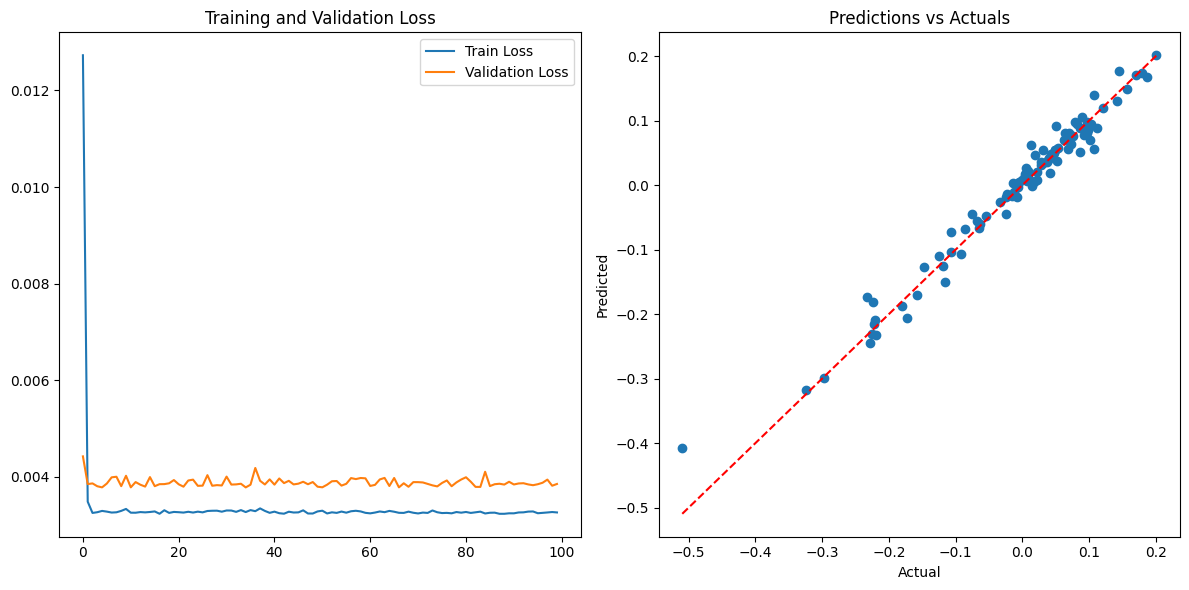

In [14]:
# Step 6: Main function
def main(data_file_path):

    # Load and preprocess data
    print("Loading and preprocessing data...")
    raw_data, quarterly_data, monthly_data = load_and_preprocess_data(data_file_path)

    # Define parameters
    input_features = ['Returns', 'Volatility', 'RSI', 'Volume']
    target_feature = 'Close'
    batch_size = 16

    # Hyperparameters to tune
    learning_rates = [0.001, 0.0001, 0.01]  # Experiment 1: Learning Rate
    hidden_dims = [32, 64, 128]             # Experiment 2: Hidden Dimension
    sequence_lengths = [4, 8, 12]           # Experiment 3: Sequence Length

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Experiment 1: Tune Learning Rate
    print("Experiment 1: Tuning Learning Rate")
    for lr in learning_rates:
        print(f"Training with Learning Rate = {lr}")
        dataset = TimeSeriesDataset(
            quarterly_data,
            seq_length=8,
            features=input_features,
            targets=target_feature
        )
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size, test_size]
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        trend_model = CoSTModel(
            input_dim=len(input_features),
            hidden_dim=64,
            latent_dim=32,
            output_dim=1
        )
        train_losses, val_losses = train_cost_model(
            trend_model,
            train_loader,
            val_loader,
            lr=lr,
            epochs=100,
            device=device
        )
        predictions, actuals = evaluate_model(trend_model, test_loader, dataset, device)
        print(f"Learning Rate: {lr}, Test MAE: {np.mean(np.abs(predictions - actuals))}")
        print("-" * 50)

    # Experiment 2: Tune Hidden Dimension
    print("Experiment 2: Tuning Hidden Dimension")
    for hidden_dim in hidden_dims:
        print(f"Training with Hidden Dimension = {hidden_dim}")
        dataset = TimeSeriesDataset(
            quarterly_data,
            seq_length=8,
            features=input_features,
            targets=target_feature
        )
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size, test_size]
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        trend_model = CoSTModel(
            input_dim=len(input_features),
            hidden_dim=hidden_dim,
            latent_dim=32,
            output_dim=1
        )
        train_losses, val_losses = train_cost_model(
            trend_model,
            train_loader,
            val_loader,
            lr=0.001,
            epochs=100,
            device=device
        )
        predictions, actuals = evaluate_model(trend_model, test_loader, dataset, device)
        print(f"Hidden Dim: {hidden_dim}, Test MAE: {np.mean(np.abs(predictions - actuals))}")
        print("-" * 50)

    # Experiment 3: Tune Sequence Length
    print("Experiment 3: Tuning Sequence Length")
    for seq_length in sequence_lengths:
        print(f"Training with Sequence Length = {seq_length}")
        dataset = TimeSeriesDataset(
            quarterly_data,
            seq_length=seq_length,
            features=input_features,
            targets=target_feature
        )
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size, test_size]
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        trend_model = CoSTModel(
            input_dim=len(input_features),
            hidden_dim=64,
            latent_dim=32,
            output_dim=1
        )
        train_losses, val_losses = train_cost_model(
            trend_model,
            train_loader,
            val_loader,
            lr=0.001,
            epochs=100,
            device=device
        )
        predictions, actuals = evaluate_model(trend_model, test_loader, dataset, device)
        print(f"Sequence Length: {seq_length}, Test MAE: {np.mean(np.abs(predictions - actuals))}")
        print("-" * 50)

    # the final model with the best hyperparameters
    print("Training final model with best hyperparameters...")
    best_lr = 0.001
    best_hidden_dim = 128
    best_seq_length = 12

    dataset = TimeSeriesDataset(
        quarterly_data,
        seq_length=best_seq_length,
        features=input_features,
        targets=target_feature
    )
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    trend_model = CoSTModel(
        input_dim=len(input_features),
        hidden_dim=best_hidden_dim,
        latent_dim=32,
        output_dim=1
    )
    train_losses, val_losses = train_cost_model(
        trend_model,
        train_loader,
        val_loader,
        lr=best_lr,
        epochs=100,
        device=device
    )
    predictions, actuals = evaluate_model(trend_model, test_loader, dataset, device)
    print(f"Final Model Test MAE: {np.mean(np.abs(predictions - actuals))}")

    # Train the seasonal model
    print("Training seasonal model...")
    seasonal_model = SeasonalPredictionModel(
        input_dim=len(input_features),
        hidden_dim=32,
        output_dim=3
    )
    seasonal_model, train_losses, val_losses = train_seasonal_model(
    seasonal_model,
    monthly_data,
    batch_size=16,
    epochs=100,
    device=device
    )
    print("Saving trained models...")
    torch.save(trend_model.state_dict(), 'trend_model.pth')
    torch.save(seasonal_model.state_dict(), 'seasonal_model.pth')
    print("Models saved successfully!")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.scatter(actuals, predictions)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predictions vs Actuals')

    plt.tight_layout()
    plt.savefig('training_results.png')

    # Create enhanced market regime predictor
    print("Creating enhanced market regime predictor...")
    predictor = EnhancedMarketRegimePredictor(
        trend_model=trend_model,
        seasonal_model=seasonal_model,
        monthly_data=monthly_data,
        features=input_features,
        seq_length=best_seq_length,
        device=device
    )

    # Extract embeddings
    all_data_loader = DataLoader(dataset, batch_size=batch_size)
    predictor.extract_embeddings(all_data_loader)

    # Example prediction
    example_quarter = "2024Q3"
    example_sector = "Technology"
    print(f"Predicting trend for {example_sector} in {example_quarter}...")
    prediction = predictor.predict_trend(example_quarter, example_sector)
    print(f"Predicted trend: {prediction}")

    return trend_model, predictor


if __name__ == "__main__":
    data_file_path = "/content/melted_data.csv"
    model, predictor = main(data_file_path)
    while True:
        quarter = input("Enter quarter (e.g., 2026Q3) or 'q' to quit: ")
        if quarter.lower() == 'q':
            break

        sector = input("Enter sector (Technology, Financial, Energy, etc.): ")
        prediction = predictor.predict_trend(quarter, sector)
        trend = "Upward" if prediction > 0 else "Downward"
        adj_prediction = abs(prediction) * 100
        print(f"Predicted trend for {sector} in {quarter}: {adj_prediction} %")
        visualization_result = predictor.visualize_prediction(quarter, sector)
        print(visualization_result)